# Travelogues classifier evaluation (standard ML)

## Results

In [74]:
# gather results and plot them
import pandas as pd

results = pd.read_csv(result_output)
results.round(2)

,Classifier,Precision,Recall,Accuracy,F1
0,Dummy (1-2),0.41,0.52,0.50,0.46
1,Multi NB (1-2),0.47,1.00,0.53,0.64
2,SVM (1-2),0.88,1.00,0.94,0.93
3,Log (1-2),0.88,1.00,0.94,0.93
4,Dummy (1-2) legacy,0.65,0.46,0.49,0.53
5,Multi NB (1-2) legacy,0.73,1.00,0.76,0.85
6,SVM (1-2) legacy,0.95,0.91,0.91,0.93
7,Log (1-2) legacy,0.95,0.95,0.94,0.95


## 0. Parameters

In [25]:
# legacy ground truth
# True uses only the ground truth used for the creation of the paper, False also inludes travelogues added later
legacy = True

# century
# this defines the century to be used, see travelogues-corpus for more info
# valid options: see travelogues-corpus
century = '16th_century'

In [27]:
# results file
result_output = 'results/results_%s.csv' % century
# with open(result_output, 'w+', encoding='utf-8') as results:
#     results.write('Classifier,Precision,Recall,Accuracy,F1\n')

# scoring parameters for cross-fold validation
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score

scoring = {'p_cross': make_scorer(precision_score, average='macro'),
          'r_cross': make_scorer(recall_score, average='macro'),
          'f1_cross': make_scorer(f1_score, average='macro'),
          'a_balanced_cross': make_scorer(balanced_accuracy_score)}

In [29]:
# loading the data

from sklearn.datasets import load_files

# groundtruth
if legacy is True:
    # data directory
    books = 'groundtruth/%s/' % century
    ground_truth = load_files(books,
                              description='Ground truth',
                              encoding='utf-8',
                              categories=['travelogues-legacy', 'non-travelogues'])
else:
    # data directory
    books = '../travelogues-corpus/%s/books/' % century
    ground_truth = load_files(books,
                              description='Ground truth',
                              encoding='utf-8',
                              categories=['travelogues', 'non-travelogues'])

X_ground_truth, y_ground_truth = ground_truth.data, ground_truth.target
class_names = ground_truth.target_names

# currently disabled, as we only provide the ground truth at the moment
# # candidates
# candidates = load_files(books,
#                         description='Travelogue candidates',
#                         encoding='utf-8',
#                         categories=['other'])

# X_candidates, y_candidates = candidates.data, candidates.target

In [30]:
# confusion matrix plot

import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 1. Baseline classification

In [53]:
# split into training and test data

from sklearn.model_selection import train_test_split

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_ground_truth, y_ground_truth, 
                                                                        random_state=42, shuffle=True)

In [54]:
# special case for Multi NB

from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(ngram_range=(1, 2), token_pattern='(?u)\\b\\w\\w+\\b')

X_train_base_count = count_vect.fit_transform(X_train_base)
X_test_base_count = count_vect.transform(X_test_base)

In [55]:
# transform text into vectors, and
# transform into tf-idf values

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

hash_vect = HashingVectorizer(ngram_range=(1, 2), token_pattern='(?u)\\b\\w\\w+\\b')

X_train_base = hash_vect.fit_transform(X_train_base)

# only transform, no fitting - as dictionary could be different to the training data
X_test_base = hash_vect.transform(X_test_base)

### 1.1 Random

In [56]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='stratified')

In [57]:
# perform the classification a number of times, to account for the small training data
# store metrics from each iteration

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm

votes_dummy_p = []
votes_dummy_r = []
votes_dummy_a = []
votes_dummy_f1 = []

# tqdm() gives a nice progress bar
# 1000 iterations because the data set is small - can reduce or set to 1 if more data available (no big changes between runs)
for i in tqdm(range(0, 1000)):
    dummy_clf.fit(X_train_base, y_train_base)
    predicted = dummy_clf.predict(X_test_base)
    
    votes_dummy_p.append(precision_score(y_test_base, predicted))
    votes_dummy_r.append(recall_score(y_test_base, predicted))
    votes_dummy_a.append(accuracy_score(y_test_base, predicted))
    votes_dummy_f1.append(f1_score(y_test_base, predicted))

100%|██████████| 1000/1000 [00:07<00:00, 134.87it/s]


In [58]:
# output average metrics

import numpy as np

print('average precision: %f' % np.mean(votes_dummy_p))
print('average recall: %f' % np.mean(votes_dummy_r))
print('average accuracy: %f' % np.mean(votes_dummy_a))
print('average f1: %f' % np.mean(votes_dummy_f1))

with open(result_output, 'a', encoding='utf-8') as results:
    if legacy is True:
        results.write('Dummy (1-2) legacy,%f,%f,%f,%f\n' % (np.mean(votes_dummy_p), np.mean(votes_dummy_r), np.mean(votes_dummy_a), np.mean(votes_dummy_f1)))
    else:
        results.write('Dummy (1-2),%f,%f,%f,%f\n' % (np.mean(votes_dummy_p), np.mean(votes_dummy_r), np.mean(votes_dummy_a), np.mean(votes_dummy_f1)))

average precision: 0.649080
average recall: 0.457909
average accuracy: 0.489265
average f1: 0.532461


### 1.2 Multinominal Naive Bayes

In [59]:
# sklearn Multinominal NaiveBayes, a classic for text classification

from sklearn.naive_bayes import MultinomialNB

multiNB_clf = MultinomialNB()

In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

multiNB_clf.fit(X_train_base_count, y_train_base)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [61]:
from sklearn.model_selection import cross_validate
from numpy import average

scores_multiNB = cross_validate(multiNB_clf, X_train_base_count, y_train_base,
                                scoring=scoring, cv=5, return_train_score=True)

for score in scores_multiNB:
    print(score, ':', round(average(scores_multiNB[score]), 2))

fit_time : 1.32
score_time : 0.32
test_p_cross : 0.76
train_p_cross : 0.98
test_r_cross : 0.72
train_r_cross : 0.98
test_f1_cross : 0.69
train_f1_cross : 0.98
test_a_balanced_cross : 0.72
train_a_balanced_cross : 0.98


In [62]:
# test on held- out dataset
import numpy as np

predicted = multiNB_clf.predict(X_test_base_count)

multiNB_p = precision_score(y_test_base, predicted)
multiNB_r = recall_score(y_test_base, predicted)
multiNB_f1 = f1_score(y_test_base, predicted)
multiNB_a = accuracy_score(y_test_base, predicted)

print('precision: %f' % multiNB_p)
print('recall: %f' % multiNB_r)
print('accuracy: %f' % multiNB_a)
print('f1: %f' % multiNB_f1)

with open(result_output, 'a', encoding='utf-8') as results:
    if legacy is True:
        results.write('Multi NB (1-2) legacy,%f,%f,%f,%f\n' % (multiNB_p, multiNB_r, multiNB_a, multiNB_f1))
    else:
        results.write('Multi NB (1-2),%f,%f,%f,%f\n' % (multiNB_p, multiNB_r, multiNB_a, multiNB_f1))

precision: 0.733333
recall: 1.000000
accuracy: 0.764706
f1: 0.846154


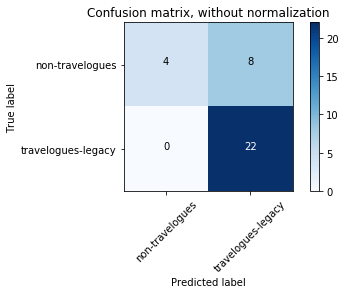

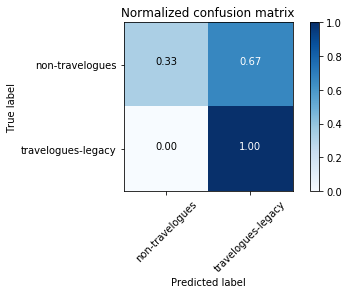

In [63]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_base, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 1.3 Support Vector Machine

In [64]:
# sklearn SVM classifier, described as best for text classification problems

from sklearn.linear_model import SGDClassifier

svm_clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=50, tol=None)

In [65]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

svm_clf.fit(X_train_base, y_train_base)

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=50,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [66]:
from sklearn.model_selection import cross_validate
from numpy import average

scores_svm_clf = cross_validate(svm_clf, X_train_base, y_train_base,
                                scoring=scoring, cv=5, return_train_score=True)

for score in scores_svm_clf:
    print(score, ':', round(average(scores_svm_clf[score]), 2))

fit_time : 4.11
score_time : 0.02
test_p_cross : 0.91
train_p_cross : 0.99
test_r_cross : 0.91
train_r_cross : 1.0
test_f1_cross : 0.9
train_f1_cross : 0.99
test_a_balanced_cross : 0.91
train_a_balanced_cross : 1.0


In [67]:
# test on held-out dataset
predicted = svm_clf.predict(X_test_base)
    
svm_p = precision_score(y_test_base, predicted)
svm_r = recall_score(y_test_base, predicted)
svm_a = accuracy_score(y_test_base, predicted)
svm_f1 = f1_score(y_test_base, predicted)

import numpy as np

print('precision: %f' % svm_p)
print('recall: %f' % svm_r)
print('accuracy: %f' % svm_a)
print('f1: %f' % svm_f1)

with open(result_output, 'a', encoding='utf-8') as results:
    if legacy is True:
        results.write('SVM (1-2) legacy,%f,%f,%f,%f\n' % (svm_p, svm_r, svm_a, svm_f1))
    else:
        results.write('SVM (1-2),%f,%f,%f,%f\n' % (svm_p, svm_r, svm_a, svm_f1))

precision: 0.952381
recall: 0.909091
accuracy: 0.911765
f1: 0.930233


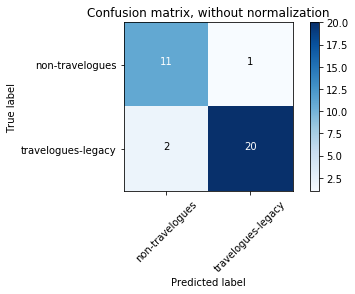

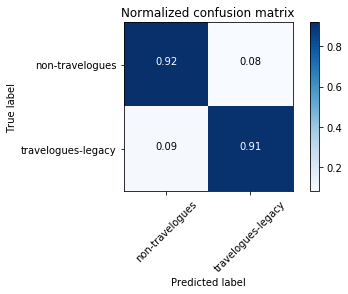

In [68]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_base, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 1.4 Logistic Regression

In [69]:
# sklearn SVM classifier, described as best for text classification problems

from sklearn.linear_model import SGDClassifier

log_clf = SGDClassifier(loss='log', penalty='l2', alpha=1e-3, random_state=42, max_iter=50, tol=None)

In [70]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

log_clf.fit(X_train_base, y_train_base)

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=50,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=None, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [71]:
from sklearn.model_selection import cross_validate
from numpy import average

scores_log_clf = cross_validate(log_clf, X_train_base, y_train_base,
                                scoring=scoring, cv=5, return_train_score=True)

for score in scores_log_clf:
    print(score, ':', round(average(scores_log_clf[score]), 2))

fit_time : 6.1
score_time : 0.02
test_p_cross : 0.88
train_p_cross : 0.97
test_r_cross : 0.88
train_r_cross : 0.98
test_f1_cross : 0.88
train_f1_cross : 0.97
test_a_balanced_cross : 0.88
train_a_balanced_cross : 0.98


In [72]:
# test on held-out dataset
predicted = log_clf.predict(X_test_base)
    
log_p = precision_score(y_test_base, predicted)
log_r = recall_score(y_test_base, predicted)
log_a = accuracy_score(y_test_base, predicted)
log_f1 = f1_score(y_test_base, predicted)

import numpy as np

print('precision: %f' % log_p)
print('recall: %f' % log_r)
print('accuracy: %f' % log_a)
print('f1: %f' % log_f1)

with open(result_output, 'a', encoding='utf-8') as results:
    if legacy is True:
        results.write('Log (1-2) legacy,%f,%f,%f,%f\n' % (log_p, log_r, log_a, log_f1))
    else:
        results.write('Log (1-2),%f,%f,%f,%f\n' % (log_p, log_r, log_a, log_f1))

precision: 0.954545
recall: 0.954545
accuracy: 0.941176
f1: 0.954545


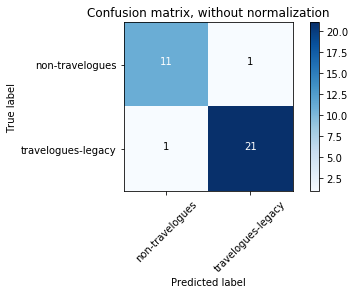

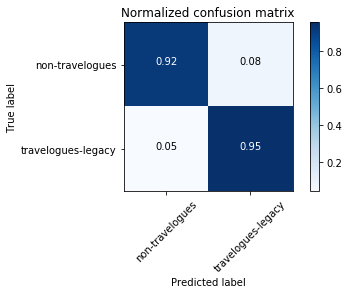

In [73]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_base, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()